# Lab: RNNs for Sentiment Analysis (with Attention)

## Daniel Toribio, Alejo González, Andrés Navarro
------------------------------------------------------

*Pablo M. Olmos pamartin@ing.uc3m.es*


------------------------------------------------------

In this notebook your goal is to take your solution to the previous Lab (Sentiment Analysis with RNNs) and add a simple attention layer before the classifier. Let $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ be the RNN output states ($\ell$ is the last state before feeding the garbage tokens):
- We will use $\mathbf{h}_\ell$ as the query ($\mathbf{q}=\mathbf{h}_\ell$)
- $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ are the keys
- Construct a two-layer MLP to construct the unnormalized weights $w_j=a(\mathbf{q},\mathbf{h}_j)$, $j=1,\ldots,\ell$. For the intermediate layer, use $tanh()$ activation.
- Normalized weights are given by $\mathbf{\alpha}=\text{Softmax}(w_1,\ldots,w_\ell)$.
- Input to the classifier is
\begin{align}
\mathbf{c} = \sum_{j=1}^{\ell}\alpha_j \mathbf{h}_j
\end{align}

Analyze if performance is improved and visualize the attention weights for a couple of cases.

**Note:** While you do not have to code much more given the solution of the previous lab, it is tricky to code the attention layer efficiently.

**Note 2:** Note we do NOT include in the attention module the states corresponding to processing the garbage token # to normalize lengths. It's important to keep this in mind. You can do this by masking the unnormalized weights $w_j$ if you compute then for the whole RNN output sequence.


In [2]:
# To use it in colab, update spacy
!pip install --upgrade spacy

In [3]:
# Download language model

!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import numpy as np
import pandas as pd
import spacy


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [5]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In [6]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]


def code_opinion(l):

    d = 0

    if (l=='negative\n'):

        d = 1

    elif (l=='positive\n'):

        d = 2

    return d

labels = np.array([code_opinion(l) for l in opinions])


In [7]:
df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

df

,Phrase,Opinion
0,"According to Gran , the company has no plans t...",neutral\n
1,With the new production plant the company woul...,positive\n
2,"For the last quarter of 2010 , Componenta 's n...",positive\n
3,"In the third quarter of 2010 , net sales incre...",positive\n
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive\n
...,...,...
5712,Operating result for the 12-month period decre...,negative\n
5713,HELSINKI Thomson Financial - Shares in Cargote...,negative\n
5714,LONDON MarketWatch -- Share prices ended lower...,negative\n
5715,Operating profit fell to EUR 35.4 mn from EUR ...,negative\n


In [8]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()

labels_bin[labels_bin==2] = 0

idx_data = np.arange(0,len(df),1)

# Separamos train de test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

In [9]:
nlp = spacy.load("en_core_web_md") # Language model


docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) and stopping words
def normalize(doc):

    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]

norm_docs = [normalize(d) for d in docs]



In [10]:
# List with the length for each sentence

lengths = [len(d) for d in norm_docs]

# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])

In [11]:
# We add as many junk tokens (#) as needed to equalize the length of each sentence to max_l

garbage_token = nlp('#') # Junk token --> #

# We normalize the dataset

norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]

# Train documents

docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [lengths[d] for d in idx_train]

# Validation documents

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [lengths[d] for d in idx_val]

# documentos test

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [lengths[d] for d in idx_test]

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class RNNWithAttention(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, batch_size=50,lr=0.0005, prob=0.5, saved_files='/content/saved_models/RNN_sentiment_analysis'):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=prob)
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )
        self.lr = lr # Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer

        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.batch_size = batch_size

        self.saved_files = saved_files

    def forward(self, x, lengths, h0=None):
      batch_size = x.size(0)
      seq_length = x.size(1)

      # Compute the RNN output (sequence of states for the whole input)
      r_out, _ = self.rnn(x)

      # Compute attention weights
      keys = r_out[:, :, :]  # All states
      query = torch.stack([r_out[d, lengths[d] - 1, :] for d in range(batch_size)]) # Last state before garbage tokens
      query = query.unsqueeze(1).repeat(1, seq_length, 1)  # Repeat query for each time step
      attn_input = torch.cat((keys, query), dim=2)  # Concatenate keys and query
      attn_weights = self.attention(attn_input).squeeze(2)  # Apply attention mechanism

      # Apply attention weights to RNN outputs
      attn_weights_masked = torch.zeros_like(r_out)  # Create a tensor with zeros
      for i, length in enumerate(lengths):
          attn_weights_masked[i, :length, 0] = attn_weights[i, :length]  # Mask the attention weights for padding positions
      attended_states = r_out * attn_weights_masked  # Element-wise multiplication

      # Sum the attended states
      attended_sum = torch.sum(attended_states, dim=1)

      # Apply dropout
      attended_sum = self.dropout(attended_sum)

      # Classify
      output = self.fc1(attended_sum)
      output = self.logsoftmax(output)

      return output, attn_weights




    def predict_proba(self,docs,lengths,Y=None):

        '''
        We use this method to get the output of the network given a set of documents. If label is provided,
        we get accuracy.

        - docs: documents, each encoded as a list of spacy tokens. They are length-normalized.
        - lengths: real length of each document.
        - Y: labels
        '''
        accuracy = 0.0

        with torch.no_grad():

            x_input = torch.Tensor([[w.vector for w in d] for d in docs])

            logprobs,weights = self.forward(x_input,lengths)
            logprobs = logprobs.detach().numpy()
            if(len(Y)>0):

                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]

        return logprobs,accuracy,weights


    def fit(self,docs_train,docs_val,Y,Yval,len_train,len_val,epochs=40,print_every=5):

        '''
        Método de entrenamiento.

        - docs_train, docs_val: training/validation documents  (each is a list of spacy tokens).
          Normalized in length!
        - len_train/len_val: real lengths
        '''

        self.print_every = print_every

        self.epochs=epochs

        # Optimization Loop

        self.num_train = len(docs_train) # Number of training points

        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches

        self.num_val = len(docs_val) # Number of validation points

        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero of validation batches

        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels

        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels


        for e in range(int(self.epochs)):

            self.train() # Activate dropout

            # Random data permutation

            idx = np.random.permutation(self.num_train)

            running_loss = 0.

            for i in range(int(self.num_batchs)):

                self.optim.zero_grad()

                # Indices of the data entering the batch

                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                # Just in case there are empty documents, we ignore them
                idx_batch = [d for d in idx_batch if len_train[d]>0]

                # We code each document using the sequences of word embeddings

                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])

                # We compute the classifier output for every data

                out,_ = self.forward(x_input,[len_train[d] for d in idx_batch])

                # Cost function and gradient descent step

                loss = self.criterion(out,labels[idx_batch])

                running_loss += loss.item()

                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                # SGD steps

                self.optim.step()

            self.loss_during_training.append(running_loss/self.num_batchs)

            # We save model parameters

            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')

            # We repeat for validation

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                idx = np.random.permutation(self.num_val)

                running_loss = 0.

                for i in range(int(self.num_batchs_val)):

                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                    # Just in case there are empty documents, we ignore them
                    idx_batch = [d for d in idx_batch if len_val[d]>0]

                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])

                    out,_ = self.forward(x_input,[len_val[d] for d in idx_batch])

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)



            if(e % self.print_every == 0):

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")



In [33]:
# Instantiate the model
input_size = 300  # Assuming word embeddings of size 300
output_size = 2
hidden_dim = 64
n_layers = 2
rnn_with_attention = RNNWithAttention(input_size, output_size, hidden_dim, n_layers)
rnn_with_attention.fit(docs_train,docs_val,torch.Tensor(y_train),torch.Tensor(y_val),len_train,len_val,epochs=40,print_every=1)

Training loss after 0 epochs: 0.6428014921815428. Validation loss: 0.5908072193463644
Training loss after 1 epochs: 0.580016942056891. Validation loss: 0.5464885234832764
Training loss after 2 epochs: 0.5522405741965934. Validation loss: 0.5145010153452555
Training loss after 3 epochs: 0.530470266325833. Validation loss: 0.4894112315442827
Training loss after 4 epochs: 0.5117769812884396. Validation loss: 0.46896592941549087
Training loss after 5 epochs: 0.487883647419002. Validation loss: 0.4518336024549272
Training loss after 6 epochs: 0.4674535095691681. Validation loss: 0.42470281488365597
Training loss after 7 epochs: 0.4508029059188007. Validation loss: 0.4066200488143497
Training loss after 8 epochs: 0.4349363883064218. Validation loss: 0.38419175810284084
Training loss after 9 epochs: 0.40575093112579763. Validation loss: 0.37350242336591083
Training loss after 10 epochs: 0.39016220136864543. Validation loss: 0.34521716667546165
Training loss after 11 epochs: 0.3824960413860948

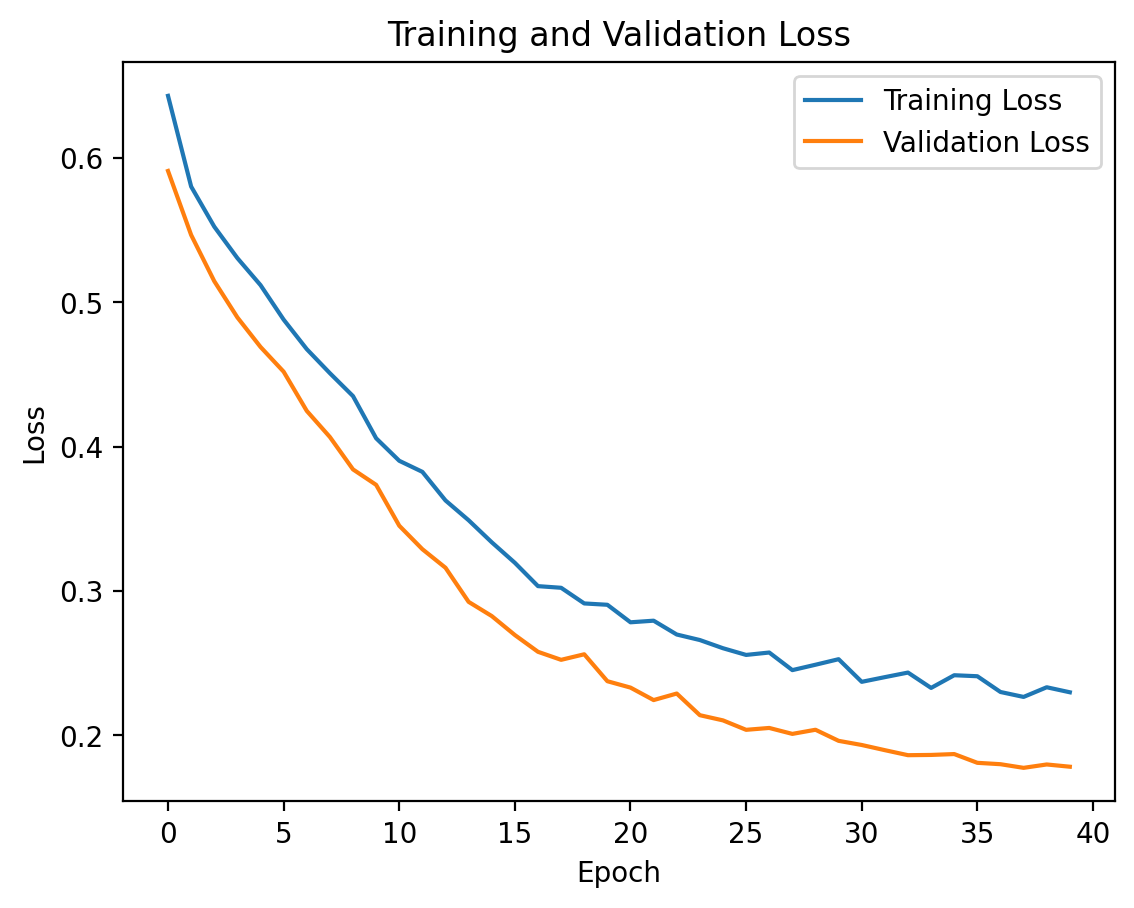

In [34]:
# Plotting the train/val loss

plt.plot(range(len(rnn_with_attention.loss_during_training)), rnn_with_attention.loss_during_training, label='Training Loss')
plt.plot(range(len(rnn_with_attention.valid_loss_during_training)), rnn_with_attention.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [35]:
# Recovering the best validation parameters

idx_min = np.argsort(rnn_with_attention.valid_loss_during_training)

rnn_with_attention.load_state_dict(torch.load(rnn_with_attention.saved_files+'_epoch_'+str(idx_min[0])+'.pth'))

<All keys matched successfully>

In [37]:
logprobs,acc,weights =rnn_with_attention.predict_proba(docs_test,len_test,y_test)

probs = np.exp(logprobs)

print(f"The test accuracy is {acc}")

The test accuracy is 0.951048951048951


In [42]:
print(len(weights[0]))

35


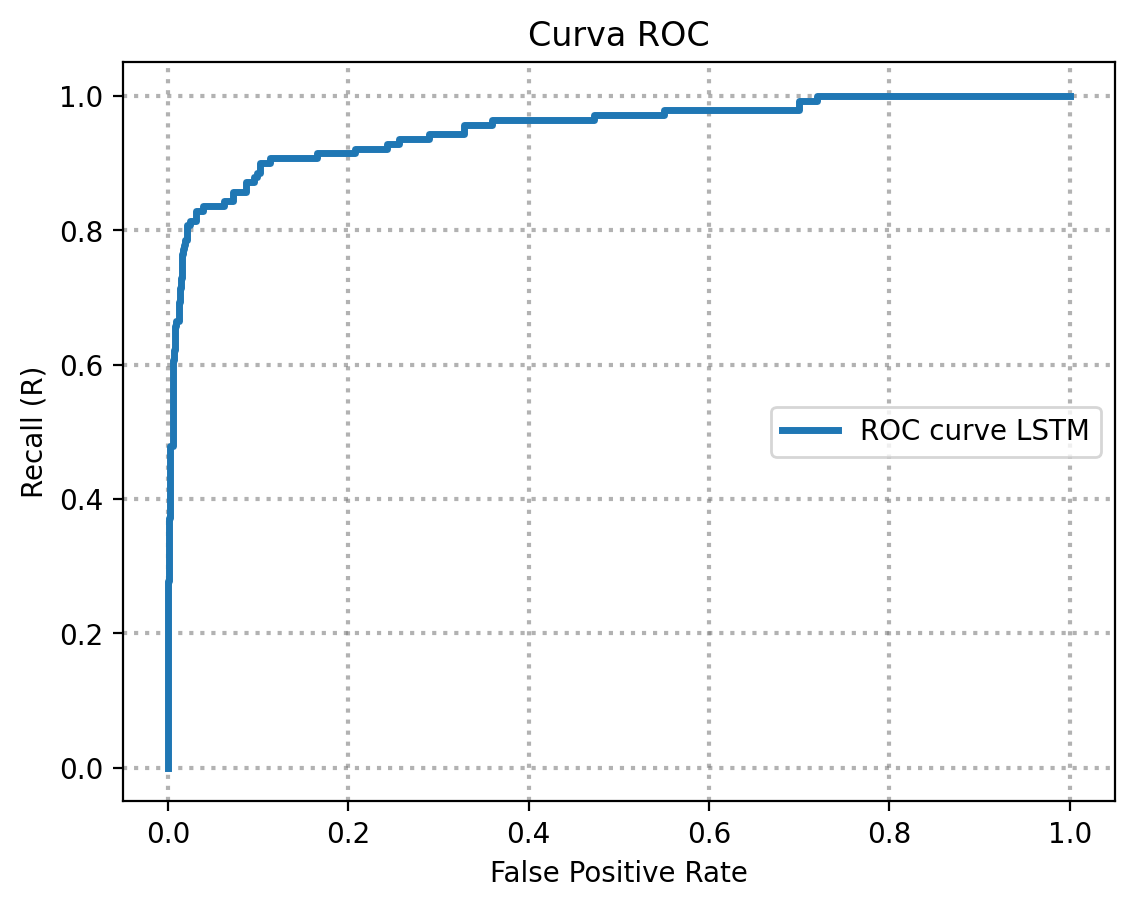

AUC ROC for LSTM is 0.9510671599317018


In [38]:
from sklearn import metrics

fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1)

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='ROC curve LSTM')
plt.legend(loc=7)
plt.grid(True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"AUC ROC for LSTM is {area_roc_LSTM}")